### This code provides a geospatial analysis of popular flight routes worldwide is presented, along with the visualization of all my flights taken over the past 10 years.

In [1]:
%reset -f

In [2]:
# Importing necessary libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

# Reading the airports data
airports = pd.read_csv("../resources/airports", delimiter=',', names=['id', 'name', 'city', 'country', 'iata', 
                                                                   'icao', 'lat', 'long', 'altitude', 'timezone',
                                                                   'dst', 'tz', 'type', 'source'])
print(airports.head())

   id                                         name          city  \
0   1                               Goroka Airport        Goroka   
1   2                               Madang Airport        Madang   
2   3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3   4                               Nadzab Airport        Nadzab   
4   5  Port Moresby Jacksons International Airport  Port Moresby   

            country iata  icao       lat        long  altitude timezone dst  \
0  Papua New Guinea  GKA  AYGA -6.081690  145.391998      5282       10   U   
1  Papua New Guinea  MAG  AYMD -5.207080  145.789001        20       10   U   
2  Papua New Guinea  HGU  AYMH -5.826790  144.296005      5388       10   U   
3  Papua New Guinea  LAE  AYNZ -6.569803  146.725977       239       10   U   
4  Papua New Guinea  POM  AYPY -9.443380  147.220001       146       10   U   

                     tz     type       source  
0  Pacific/Port_Moresby  airport  OurAirports  
1  Pacific/Port_More

In [3]:
# Reading the routes data
routes = pd.read_csv("../resources/routes", delimiter=',', names=['airline', 'id', 'source_airport', 'source_airport_id',
                                                               'destination_airport', 'destination_airport_id', 'codeshare',
                                                               'stops', 'equitment'])
print(routes.shape)

(67663, 9)


In [4]:
# Selecting relevant columns for source airports
source_airports = airports[['name', 'iata', 'icao', 'lat', 'long']]

# Creating a copy for destination airports
destination_airports = source_airports.copy()

# Renaming columns for source and destination airports
source_airports.columns = [str(col) + '_source' for col in source_airports.columns]
destination_airports.columns = [str(col) + '_destination' for col in destination_airports.columns]

In [5]:
# Selecting relevant columns from routes dataframe
routes = routes[['source_airport', 'destination_airport']]

# Merging with source airports dataframe based on source airport IATA code
routes = pd.merge(routes, source_airports, left_on='source_airport', right_on='iata_source')

# Merging with destination airports dataframe based on destination airport IATA code
routes = pd.merge(routes, destination_airports, left_on='destination_airport', right_on='iata_destination')

print(routes.columns)

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination'],
      dtype='object')


In [6]:
# Creating LineString geometries from source and destination coordinates
routes_geometry = [LineString([[routes.iloc[i]['long_source'], routes.iloc[i]['lat_source']], [routes.iloc[i]['long_destination'], routes.iloc[i]['lat_destination']]]) for i in range(routes.shape[0])]

# Creating a GeoDataFrame with the LineString geometries
routes_geodata = gpd.GeoDataFrame(routes, geometry=routes_geometry, crs='EPSG:4326')

In [7]:
# Creating Point geometries from airport coordinates
airports_geometry = [Point(xy) for xy in zip(airports['long'], airports['lat'])]

# Creating a GeoDataFrame with the Point geometries
airports_geodata = gpd.GeoDataFrame(airports, geometry=airports_geometry, crs='EPSG:4326')

In [8]:
# Counting the number of flights for each destination airport
flight_counts = routes['destination_airport'].value_counts().reset_index()
flight_counts.columns = ['iata_destination', 'flight_count']

# Merging the flight counts with the destination airports data
destination_airports = pd.merge(destination_airports, flight_counts, on='iata_destination', how='left', suffixes=('_source', '_destination'))

print(destination_airports.columns)

Index(['name_destination', 'iata_destination', 'icao_destination',
       'lat_destination', 'long_destination', 'flight_count'],
      dtype='object')


In [9]:
destination_airports['flight_count'] = destination_airports['flight_count'].fillna(0).astype(int)
print(destination_airports['flight_count'].isnull().sum())

0


In [10]:
# Creating Point geometries for destination airports
dst_airports_geometry = [Point(xy) for xy in zip(destination_airports['long_destination'], destination_airports['lat_destination'])]

# Creating a GeoDataFrame for destination airports
dst_airports_geodata = gpd.GeoDataFrame(destination_airports, geometry=airports_geometry, crs='EPSG:4326')

(-7000000.0, 8800000.0)

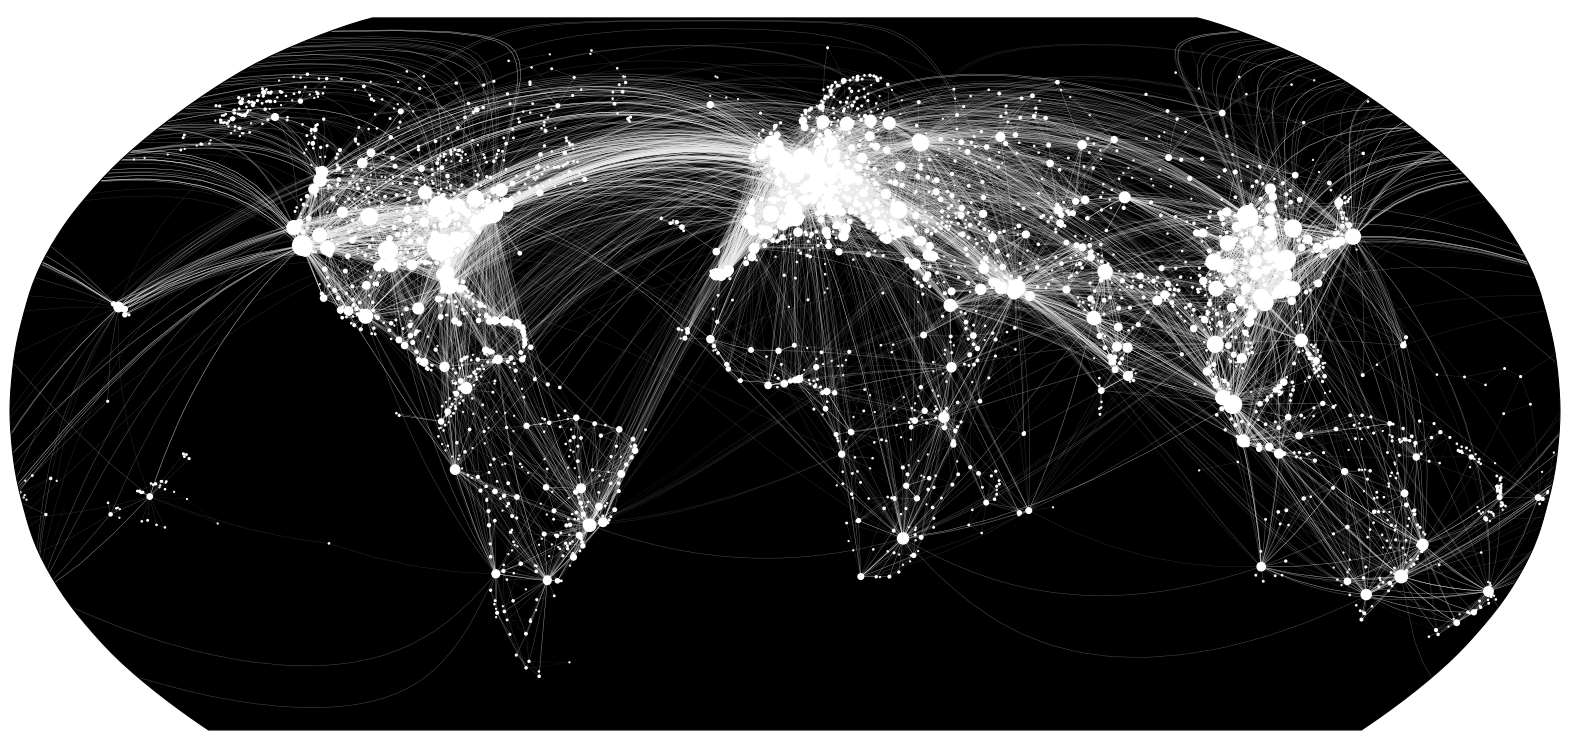

In [11]:
# Visualizing Global Flight Routes and Destination Airports
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(20,20))
ax.patch.set_facecolor('black')
routes_geodata.plot(ax=ax, transform=ccrs.Geodetic(), color='white', linewidth=0.3, alpha=0.1)

marker_size = destination_airports['flight_count'] * 0.4
colors = 'white'
airports_geodata.plot(ax=ax, transform=ccrs.Geodetic(), color=colors, markersize=marker_size)
ax.set_ylim(-7000000, 8800000)


In [12]:
# Importing my personal flight data
my_flights = pd.read_csv("../resources/myfly.csv", skiprows=1, delimiter=',', names=['DepartureIATA', 'ArrivalIATA', 'Year of Flight'])
print(my_flights.head())

  DepartureIATA ArrivalIATA  Year of Flight
0           MRV         DXB            2015
1           MRV         DXB            2017
2           MRV         DXB            2018
3           MRV         DXB            2019
4           MRV         AYT            2019


In [13]:
# Merging personal flight data with airport information
my_flight_routes = pd.merge(my_flights, airports, left_on='DepartureIATA', right_on='iata', how='left')
my_flight_routes = pd.merge(my_flight_routes, airports, left_on='ArrivalIATA', right_on='iata', how='left', suffixes=('_source', '_destination'))
print(my_flight_routes.columns)

Index(['DepartureIATA', 'ArrivalIATA', 'Year of Flight', 'id_source',
       'name_source', 'city_source', 'country_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'altitude_source',
       'timezone_source', 'dst_source', 'tz_source', 'type_source',
       'source_source', 'id_destination', 'name_destination',
       'city_destination', 'country_destination', 'iata_destination',
       'icao_destination', 'lat_destination', 'long_destination',
       'altitude_destination', 'timezone_destination', 'dst_destination',
       'tz_destination', 'type_destination', 'source_destination'],
      dtype='object')


In [14]:
# Creating LineString geometries for personal flight routes
my_flight_routes_geometry = [LineString([(row['long_source'], row['lat_source']), (row['long_destination'], row['lat_destination'])])
                          for index, row in my_flight_routes.iterrows()]

In [15]:
# Creating a GeoDataFrame for personal flight routes
my_routes_geodata = gpd.GeoDataFrame(my_flight_routes, geometry=my_flight_routes_geometry, crs='EPSG:4326')


In [16]:
# Extracting unique airport IATA codes from the personal flights data
my_airports_list = list(set(my_flights['DepartureIATA'].unique()) | set(my_flights['ArrivalIATA'].unique()))

print(my_airports_list)

['DXB', 'SVO', 'BAH', 'TLV', 'MRV', 'LAS', 'PMO', 'IST', 'KUL', 'AUH', 'ABQ', 'AYT', 'BEY', 'MAD', 'VIE', 'STV', 'VKO', 'GYD', 'VCE', 'SFO', 'STW', 'CDG', 'MPL', 'DME', 'LED', 'MRS', 'CPH', 'JFK', 'OSL', 'MXP', 'DMM', 'BCN']


In [17]:
# Creating GeoDataFrame for personal airports with flight count
geometry = [Point(xy) for xy in zip(airports['long'], airports['lat'])]
my_airports_gdf = gpd.GeoDataFrame(airports, crs='EPSG:4326', geometry=geometry)
my_airports_gdf = my_airports_gdf[my_airports_gdf['iata'].isin(my_airports_list)]

# Merging flight counts with personal airports GeoDataFrame
my_airports_gdf = my_airports_gdf.merge(destination_airports[['iata_destination', 'flight_count']], left_on='iata', right_on='iata_destination', how='left')
my_airports_gdf['flight_count'] = my_airports_gdf['flight_count'].fillna(0)
my_airports_gdf.drop(columns=['iata_destination'], inplace=True)

print(my_airports_gdf.head())

     id                                  name        city  country iata  icao  \
0   609            Copenhagen Kastrup Airport  Copenhagen  Denmark  CPH  EKCH   
1   644                         Oslo Lufthavn        Oslo   Norway  OSL  ENGM   
2  1218       Barcelona International Airport   Barcelona    Spain  BCN  LEBL   
3  1229  Adolfo Suárez Madrid–Barajas Airport      Madrid    Spain  MAD  LEMD   
4  1353            Marseille Provence Airport   Marseille   France  MRS  LFML   

         lat       long  altitude timezone dst                 tz     type  \
0  55.617901  12.656000        17        1   E  Europe/Copenhagen  airport   
1  60.121000  11.050200       681        1   E        Europe/Oslo  airport   
2  41.297100   2.078460        12        1   E      Europe/Madrid  airport   
3  40.471926  -3.562640      1998        1   E      Europe/Madrid  airport   
4  43.439272   5.221424        74        1   E       Europe/Paris  airport   

        source                   geometry  f

(-7000000.0, 8800000.0)

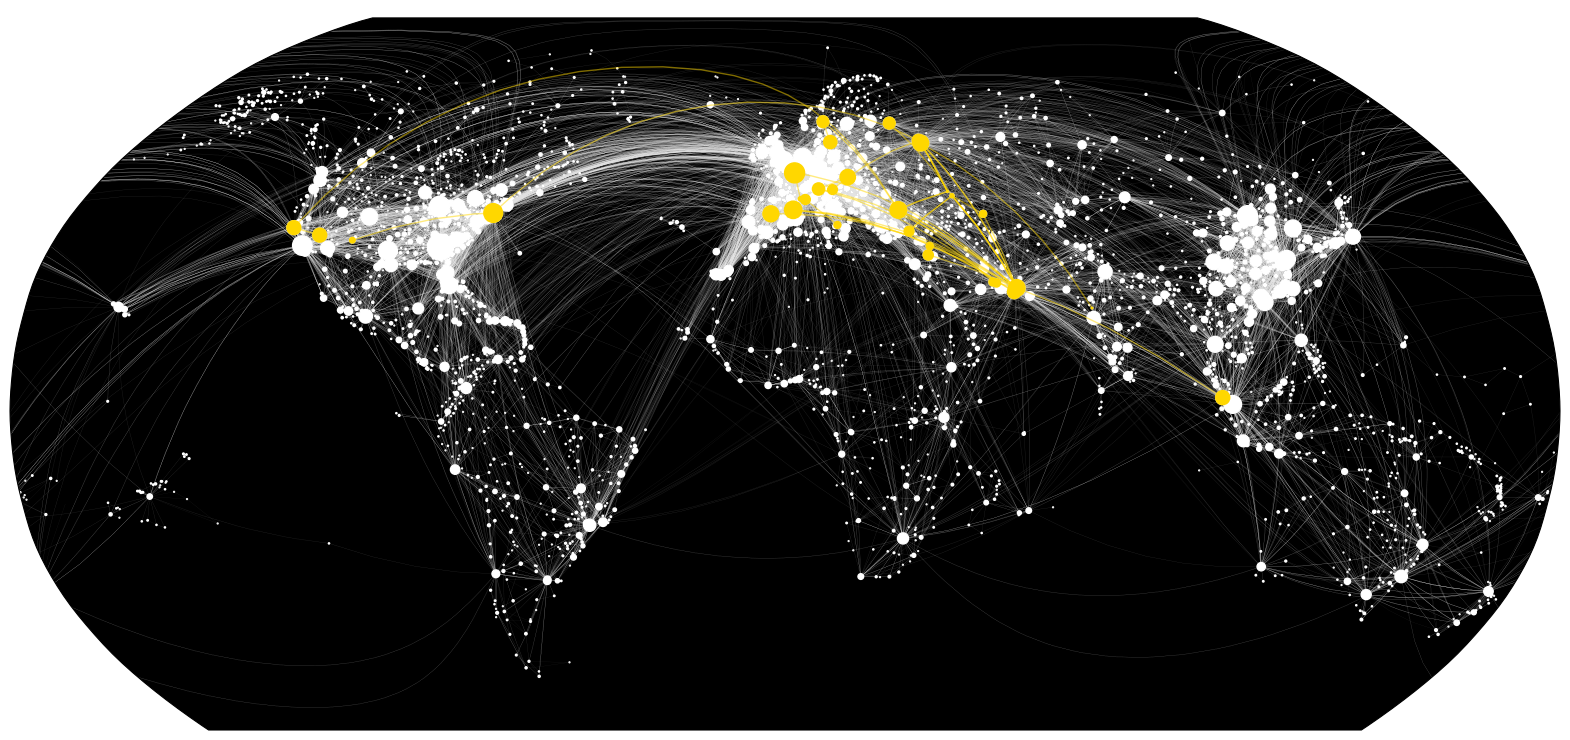

In [24]:
# Plotting my flight routes and airports along with common routes and airports

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(20,20))
ax.patch.set_facecolor('black')

# Plotting my flight routes
my_routes_geodata.plot(ax=ax, transform=ccrs.Geodetic(), color='gold', linewidth=1, alpha=0.5, zorder=5)

# Calculating marker size for my airports based on flight count
my_airports_marker_size = my_airports_gdf['flight_count'] * 0.4

# Plotting my airports with marker size based on flight count
my_airports_gdf.plot(ax=ax, transform=ccrs.Geodetic(), color='gold', markersize=my_airports_marker_size, zorder=4)

# Plotting world's flight routes with thinner lines
routes_geodata.plot(ax=ax, transform=ccrs.Geodetic(), color='white', linewidth=0.2, alpha=0.1, zorder=2)

# Calculating marker size for world's airports based on flight count
all_airports_marker_size = destination_airports['flight_count'] * 0.4

# Plotting world's airports with marker size based on flight count
airports_geodata.plot(ax=ax, transform=ccrs.Geodetic(), color='white', markersize=all_airports_marker_size, zorder=0)

ax.set_ylim(-7000000, 8800000)